In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import loggamma
import tabulate

In [162]:
df = pd.read_csv('SLS22.csv')

# 1 Uppvärmning. 
Följande uppgifter bör göra dig bekant med datamängden och förbereda data för användning när du bygger dina prediktiva modeller.

(a) Alla betyg i dataramen är för närvarande tal mellan 0 och 10. Normalisera dessa värden i dataramen så att de är mellan 0 och 1.

In [163]:
for col in df.columns:
    if df[col].dtype == np.float64:
        df[col] = df[col].apply(lambda x: x/10)

(b) Gör ett histogram för alla trickbetyg för trick 1−4. Vad observerar du? Finns det ett visst värde som dyker upp oftare än de andra? Om så är fallet, hur står detta värde i jämförelse med de andra?

<Axes: ylabel='Frequency'>

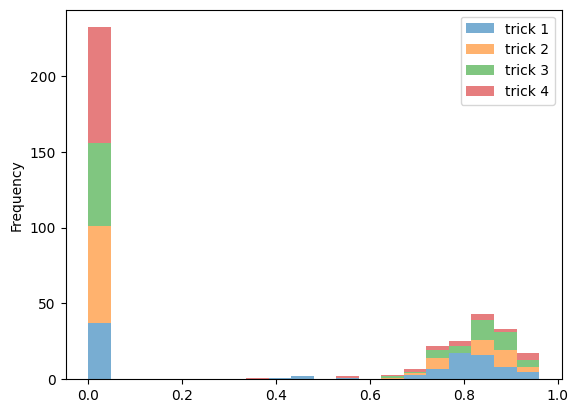

In [164]:
df[['trick 1', 'trick 2', 'trick 3', 'trick 4']].plot.hist(bins=20, stacked=True, alpha=0.6)

Svar: Det är tydligt att det absolut vanligaste talet är 0, dvs. att åkaren ej klarar trickcet.

(c) For varje trick 1−4 skapa en ny kolumn med namnet ’make i’ för i = 1, 2, 3, 4 så att värdet av ’make i’ i en given rad är 1 om skateboardåkaren landade trick i och 0 annars.

In [165]:
for i in range(1, 5):
    df[f"make {i}"] = df[f"trick {i}"].apply(lambda x: 1 if x > 0 else 0)

(d) För varje skateboardåkare skatta sannolikheten att ett trick får ett betyg som är större än 0.6 givet att skateboardåkaren landar tricket. Vad är sanno- likheten att skateboardåkaren inte lyckas landa ett visst trick? Vad observerar du? Relatera dina observationer till era observationer i del (b).

In [166]:
def compute_greater_than_point_six(group):
    # join tricks into one column if they are made
    tricks = np.concatenate([group[group[f'make {i}'] == 1][f'trick {i}'] for i in range(1, 5)])
    total = len(tricks)
    greater_than_point_six = len(tricks[tricks > 0.6])
    return pd.Series([int(total), round(greater_than_point_six/total, 2)], index=['total', 'greater than 0.6'])

greater_than_point_six = df.groupby('id').apply(compute_greater_than_point_six)
print(greater_than_point_six)

           total  greater than 0.6
id                                
Berger       2.0              1.00
Decenzo      7.0              1.00
Eaton        5.0              1.00
Foy          6.0              1.00
Fynn         6.0              1.00
Gustavo      8.0              1.00
Hoban        8.0              1.00
Hoefler      7.0              1.00
Horigome     9.0              1.00
Huston       3.0              1.00
Jordan       8.0              1.00
Joslin       9.0              1.00
Majerus      3.0              0.33
McClung      1.0              0.00
Midler       4.0              1.00
Milou        9.0              1.00
Mota         3.0              1.00
Oliveira     5.0              1.00
O’neill      3.0              1.00
Papa         7.0              1.00
Pudwill      3.0              0.33
Ribeiro C    3.0              1.00
Ribeiro G   13.0              1.00
Rodriguez    4.0              1.00
Santiago     1.0              0.00
Shirai       8.0              1.00
Silvas       3.0    

Svar: Om en skateboardare klarar tricket så får de nästan alltid ett betyg över 0.6. Detta ser man också i histogrammen.

(e) Gör ett spridningsdiagram för runbetyg 1 mot runbetyg 2. Ser du någon tydligt korrelation från diagrammet?

0.19053845069841102


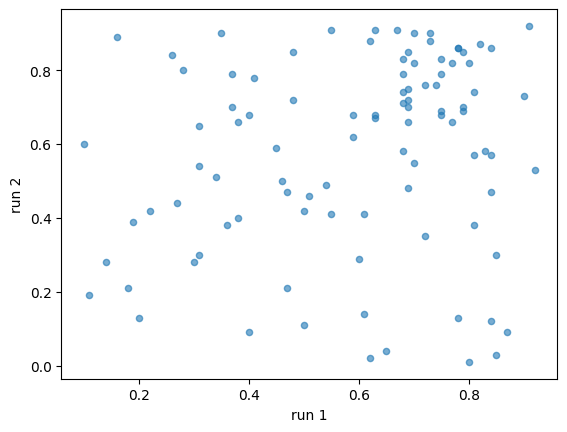

In [167]:
df.plot.scatter(x='run 1', y='run 2', alpha=0.6)
z = np.polyfit(df['run 1'], df['run 2'], 1)
p = np.poly1d(z)
ro = np.corrcoef(df['run 1'], df['run 2'])[0, 1]
print(ro)
plt.show()

Svar: Väldigt svag positiv korrerlation, ro=0.19. Många värden verkar vara koncentrerade i övre högra hörnet, men annars är spridningen väldigt stor.

# 2. En frekventistisk modell.

(a) Ge en punktskattning för varje θi, sannolikheten att skateboardåkaren i landar ett trick.
θi = x_bar, dvs. theta från ovan

(b) Ge en punktskattning för parametrarna [αi,βi]T för varje skateboardåkare i. Finns det skateboardåkare för vilka din valda punktskattning inte existera? I så fall föreslå en alternativ punktskattning för dessa αi, βi. Motivera dina val punktskattningar.

In [168]:
def estimate_alpha_beta(scores):
    mean = scores.mean()
    var = scores.var()
    if var == 0:
        return mean * 10, (1 - mean) * 10
    alpha = mean * (mean * (1 - mean) / var - 1)
    beta = (1 - mean) * (mean * (1 - mean) / var - 1)
    return alpha, beta

In [169]:
interesting_cols = ['Majerus', 'Oliveira', 'Decenzo', 'Santiago', 
                    'Papa', 'Jordan', 'Ribeiro C', 
                    'Eaton', 'Hoefler', 'O’neill',
                    'Mota', 'Shirai', 'Hoban', 'Gustavo',
                    'Foy', 'Midler']
                    
gdf = df[df["id"].isin(interesting_cols)].groupby('id')

In [170]:
def compute_stats(group):
    total_tricks = 4 * len(group)
    passed_tricks = sum(group[f'make {i}'].sum() for i in range(1, 5))
    
    trick_scores = np.concatenate([group.loc[group[f'make {i}'] == 1, f'trick {i}'] for i in range(1, 5)])
    run_scores = np.concatenate([group[f'run {i}'] for i in range(1, 3)])
    
    theta = passed_tricks / total_tricks
    alpha_trick, beta_trick = estimate_alpha_beta(trick_scores)
    alpha_run, beta_run = estimate_alpha_beta(run_scores)
    
    return pd.Series(
        [theta, alpha_trick, beta_trick, alpha_run, beta_run], 
        index=['theta', 'alpha_trick', 'beta_trick', 'alpha_run', 'beta_run']
    )

freq_params = gdf.apply(compute_stats)
print(freq_params)

              theta  alpha_trick  beta_trick   alpha_run   beta_run
id                                                                 
Decenzo    0.437500    24.455929    5.110825    4.164506   2.834664
Eaton      0.625000    75.408256   20.045233  103.573288  36.865068
Foy        0.500000    51.589516    9.104032    3.506609   4.088934
Gustavo    0.400000    70.644593   17.523386    1.228081   0.856946
Hoban      0.400000   107.698921   15.034892    3.632207   2.096826
Hoefler    0.437500    32.522583    9.403399    1.754494   0.965652
Jordan     0.400000    23.062983    3.638010    3.608210   1.228533
Majerus    0.375000     2.912773    2.724852    1.755202   2.474200
Midler     0.333333    43.723171   10.423171    1.290513   0.819317
Mota       0.250000    24.006667    6.771111    4.056173   4.573982
Oliveira   0.416667    68.878648   17.870279    5.389884   4.038485
O’neill    0.250000  1252.666250  232.708750    0.599388   0.732585
Papa       0.437500    22.314765    6.346401    

(d) Använd din modell för [Xi,Yi]T för att simulera 5000 LCQ:ar och för varje simulering extrahera de fyra skateboardåkare W = [W1,W2,W3,W4]^T med de högsta totalbetygen. Vad är typvärdet för W1, ... , W5000? De riktiga vinnarna för LCQ:en är Gustavo, Hoban, Eaton, Decenzo. Hur många av de riktiga vinnarna förutsägs av typvärdet? Vad är skattade sannolikheten för de riktiga vinnarna baserat på dina simuleringar? Av typvärdet?

In [171]:
def simulate_LCQ(theta, alpha_trick, beta_trick, alpha_run, beta_run):
    best_run = max(np.random.beta(alpha_run, beta_run, 2))
    
    trick_scores = [np.random.beta(alpha_trick, beta_trick) for _ in range(4) if np.random.uniform() < theta]
    two_best_tricks = sorted(trick_scores, reverse=True)[:2]
    
    return best_run + sum(two_best_tricks)

In [172]:
def simulate_n_LCQs(n, theta, alpha_trick, beta_trick, alpha_run, beta_run):
    result = np.zeros(n)
    for i in range(n):
        theta_i = theta if np.isscalar(theta) else theta[i]
        alpha_trick_i = alpha_trick if np.isscalar(alpha_trick) else alpha_trick[i]
        beta_trick_i = beta_trick if np.isscalar(beta_trick) else beta_trick[i]
        alpha_run_i = alpha_run if np.isscalar(alpha_run) else alpha_run[i]
        beta_run_i = beta_run if np.isscalar(beta_run) else beta_run[i]
        
        result[i] = simulate_LCQ(theta_i, alpha_trick_i, beta_trick_i, alpha_run_i, beta_run_i)
    return result

In [173]:
def LCQ_results(scores_df):
    top4_per_row = scores_df.apply(lambda row: tuple(sorted(row.nlargest(4).index.tolist())), axis=1)
    # most common top 4
    top4_groups = top4_per_row.value_counts() / len(scores_df)
    print('Vanligaste top 4:')
    print(top4_groups.head(1))
    
    top4_individually = pd.Series([item for sublist in top4_per_row for item in sublist]).value_counts() / len(top4_per_row)
    print('\nVanligaste top 4 individerna:')
    print(top4_individually.head(4))
    
    winners = ('Decenzo', 'Eaton', 'Gustavo', 'Hoban')
    print('\nSannolikheten att de fyra vinnarna vann tillsammans:')
    print(top4_groups.loc[[winners]])
    
    print('\nSannolikheten att de fyra vinnarna vann individuellt:')
    for winner in winners:
        print(winner, top4_individually.loc[winner])
    

In [174]:
columns = {}
for _, row in freq_params.iterrows():
    columns[row.name] = simulate_n_LCQs(5000, row['theta'], row['alpha_trick'], row['beta_trick'], row['alpha_run'], row['beta_run'])
frequentist_scores_df = pd.DataFrame(columns)

In [175]:
LCQ_results(frequentist_scores_df)

Vanligaste top 4:
(Hoban, Hoefler, Jordan, Shirai)    0.0128
Name: count, dtype: float64

Vanligaste top 4 individerna:
Eaton     0.4864
Jordan    0.4852
Shirai    0.4418
Hoban     0.4396
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann tillsammans:
(Decenzo, Eaton, Gustavo, Hoban)    0.0052
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann individuellt:
Decenzo 0.3434
Eaton 0.4864
Gustavo 0.3104
Hoban 0.4396


# 3. En bayesiansk modell.

(a) Föreslå en simultan apriorifördelning för parametrarna [Θi , Ai , Bi ]T för Xi där vi antar Θi ⊥ Ai, Bi för alla i. Motivera ditt val.

$\Theta_{i} \perp\!\!\!\perp A_{i}, B_{i} \implies f_{\Theta_{i}, A_{i}, B_{i}}(\theta_{i}, \beta_{i}, \alpha_{i})=f_{\Theta_{i}}(\theta_{i}) f_{A_{i}, B_{i}}(\alpha_{i}, \beta_{i})$ och vi kan därmed behandla $\Theta_{i}$ och $A_{i}, B_{i}$ separat.

$Ber(\theta_{i})$ har som konjugerad apriorifördelning $Beta(a_{i}, b_{i})$, och vi kommer därmed använda den.

$Beta(\alpha_{i}, \beta_{i})$ har ingen konjugerad apriorifördelning, men med hjälp av samma knep som i Exempel 10.8 så kan vi få följande apriorifördelning:
$$
f_{A_{i}, B_{i}}(\alpha_{i}, \beta_{i}) = \frac{\lambda^{\phi_{i}}}{\Gamma(\phi_{i})} (\alpha_{i} + \beta_{i} + 1)^{\phi_{i} - 1} e^{-\lambda_{i}(\alpha_{i} + \beta_{i} + 1)} (\alpha_{i} + \beta_{i})^{-1}
$$
Sammansatt får vi följande funktion för den simultana apriorifördelningen:
$$
f_{\Theta_{i}, A_{i}, B_{i}}(\theta_{i}, \alpha_{i}, \beta_{i}) = (\frac{\Gamma(a_{i} + b_{i})}{\Gamma(a_{i}) \Gamma(b_{i})} \theta_{i}^{a_{i}-1} (1-\theta_{i})^{b_{i}-1}) (\frac{\lambda^{\phi_{i}}}{\Gamma(\phi_{i})} (\alpha_{i} + \beta_{i} + 1)^{\phi_{i} - 1} e^{-\lambda_{i}(\alpha_{i} + \beta_{i} + 1)} (\alpha_{i} + \beta_{i})^{-1})
$$
Vi kommer använda $a_{i}=b_{i}=1$, som val för en icke-informativ fördelning för $\Theta_{i}$. Vi väljer samma värden som i Exempel 10.8 för $A_{i}, B_{i}$, dvs $\lambda_{i}=1, \phi_{i}=3$.

(b) Generera 5000 slumpmässiga utfall från aposteriorifördelningen fθi,αi,βi|Xi (θi, αi, βi|xi).
Plotta dina resulterande utfall för de marginella aposteriorifördelningarna:
fθi|Xi (θi|xi) and fαi,βi|Xi (αi, βi|xi).
Beräkna det aposteriori stickprovsmedelvärdet och den aposteriori stickprov-
sorvariansen för varje parameter θi,αi, och βi för alla skateboardåkare.

Vi utnyttjar det faktum att $f_{\Theta | \mathbf{X}}(\theta | \mathbf{x}) \propto f_{\mathbf{X} | \Theta}(\mathbf{x} | \theta) f_{\Theta}(\theta)$ tillsammans med metropolisalgoritmen som har den trevliga egenskapen att $f$ ej måste vara normaliserad. 

In [254]:
lamda = 0.5
phi = 5

def log_prior_trick(theta, alpha, beta, a = 1, b = 1):
    return (a - 1) * np.log(theta) + (b - 1) * np.log(1 - theta) + (phi - 1) * np.log(alpha + beta + 1) - lamda*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior_trick(data, theta, alpha, beta, a = 1, b = 1): # ignoring constants
    log_p = log_prior_trick(theta, alpha, beta, a, b)
    
    for x in data:
        if x == 0:
            log_p += np.log(1 - theta)
        else:
            log_p += np.log(theta) + loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)

    return log_p
        

In [255]:
def metropolis_algorithm(data, log_posterior_func, n_samples, proposal_sd, start_params):
    # Initialize the chain with the starting parameters
    current_params = start_params
    current_log_posterior = log_posterior_func(data, *current_params)

    samples = np.empty((n_samples, len(start_params)))
    for i in range(n_samples):
        proposed_params = [np.exp(np.log(param) + proposal_sd[i] * np.random.normal(0, 1, 1)[0]) for i, param in enumerate(current_params)]
        if len(start_params) == 3:
            proposed_params[0] = np.clip(proposed_params[0], 1e-6, 1-1e-6)
        
        proposed_log_posterior = log_posterior_func(data, *proposed_params)
        
        acceptance_prob = min(1, np.exp(proposed_log_posterior - current_log_posterior))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            current_params = proposed_params
            current_log_posterior = proposed_log_posterior

        samples[i] = current_params
    return samples

In [289]:
n_chains = 4
n_samples = 6000
proposal_sd = [0.3, 0.3, 0.3]

trick_samples_dict = {}
for name, group in gdf:
    theta_start = np.linspace(0.05, 0.95, n_chains)
    c_start = freq_params.loc[name, 'alpha_trick'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    d_start = freq_params.loc[name, 'beta_trick'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    
    tricks = np.concatenate([group[f'trick {i}'] for i in range(1, 5)])
    
    samples_list = []
    for i in range(n_chains):
        samples = metropolis_algorithm(tricks, log_posterior_trick, n_samples, proposal_sd, [theta_start[i], c_start[i], d_start[i]])
        samples_list.append(samples)
    trick_samples_dict[name] = samples_list

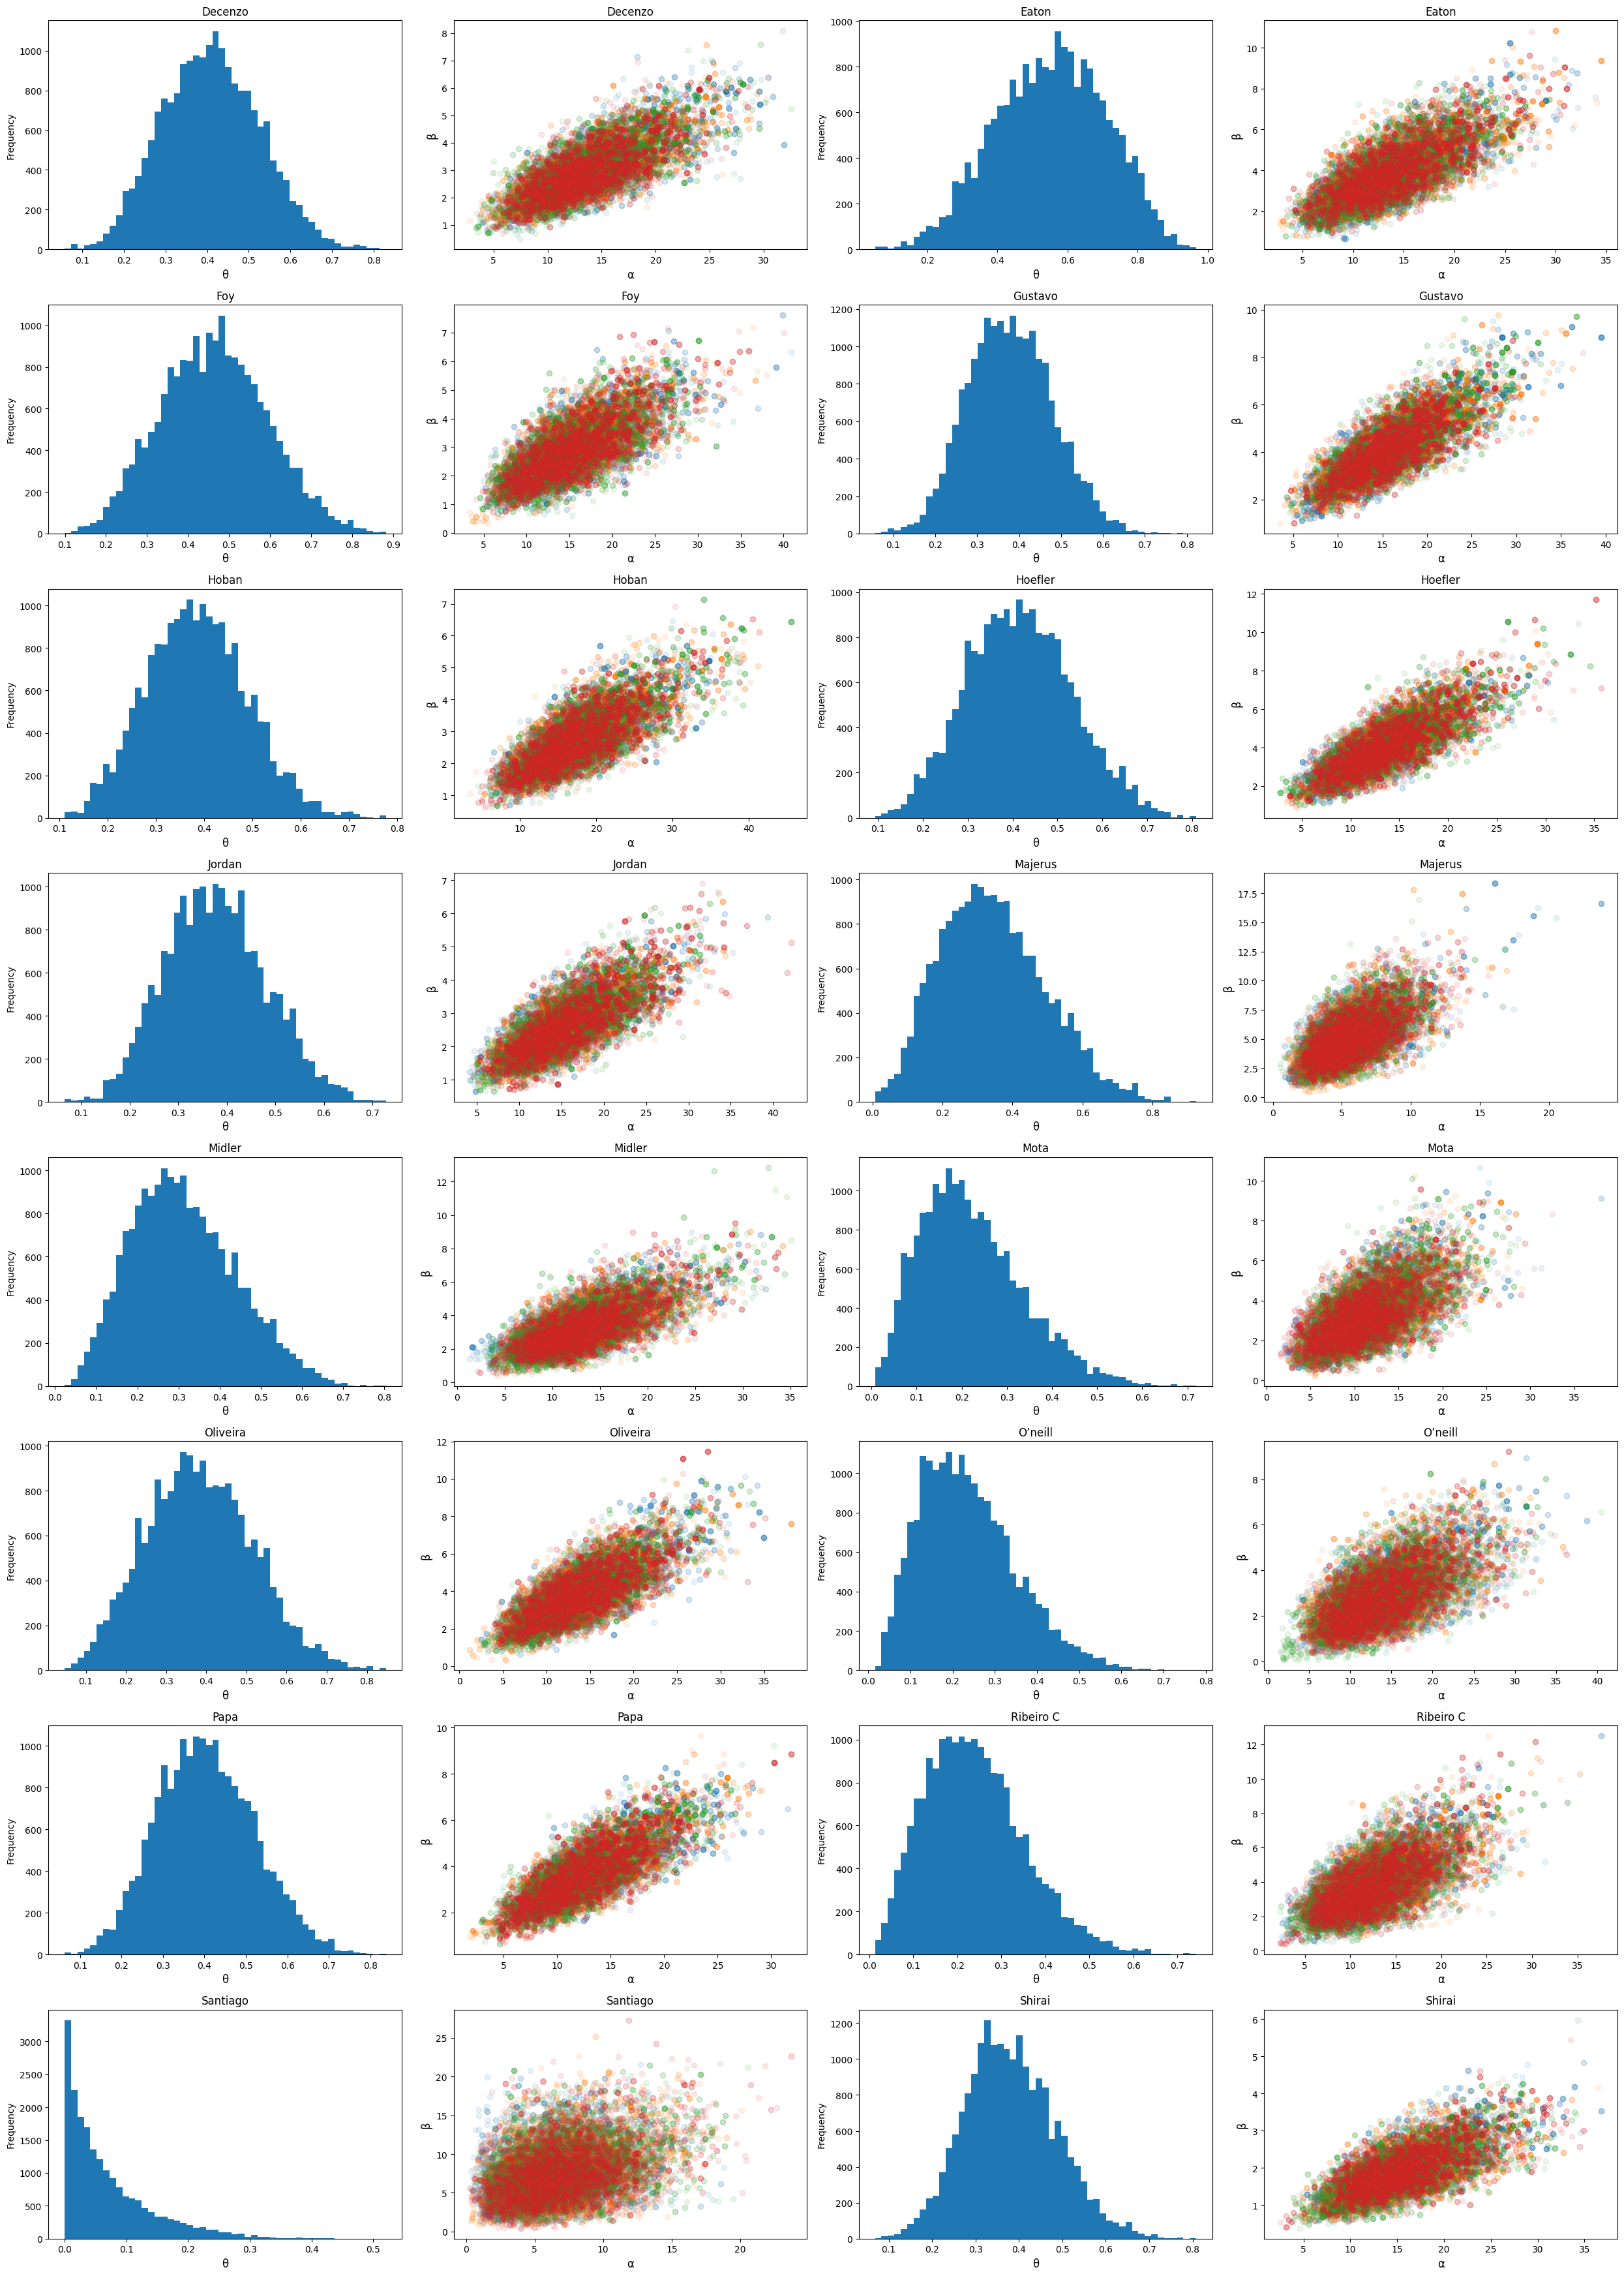

In [290]:
rows = len(trick_samples_dict) // 2
fig, axs = plt.subplots(rows, 4, figsize=(25, 25*1.4))

# hist of theta, heatmap of alpha and beta
# ignore first 1000 samples
for i, (name, samples) in enumerate(trick_samples_dict.items()):
    row = i // 2
    col = 2 * (i % 2)
    
    thetas = np.concatenate([sample[1000:, 0] for sample in samples], axis=0)
    alpha_tricks, beta_tricks = [[sample[1000:, i] for sample in samples] for i in range(1, 3)]
    
    axs[row, col].hist(thetas, bins=50)
    axs[row, col].set_title(f"{name}")
    axs[row, col].set_xlabel('θ', fontsize='large')
    axs[row, col].set_ylabel('Frequency')
    
    for j in range(n_chains):
        axs[row, col+1].plot(alpha_tricks[j], beta_tricks[j], 'o', alpha=0.1)
        axs[row, col+1].set_title(f"{name}")
        axs[row, col+1].set_xlabel('α', fontsize='large')
        axs[row, col+1].set_ylabel('β', fontsize='large')
    
plt.tight_layout()

(c) Föreslå en (simultan) apriorifördelning för parametrarna för din modell Yi från uppgift 2(c) och motivera ditt val. Du får anta att modellens parame- trar för skateboardåkaren i är oberoende av alla andra parametrar inklusive θi,αi och βi. Generera 5000 utfall från aposteriorifördelningen (se till att spara dessa utfall!) och gör ett spridningsdiagram av resultatet. Vad är stick- provsmedelvärdet och stickprovsvariansen för var och en av dina parametrar baserat på dina utfall?

In [291]:
def log_prior_run(alpha, beta):
    return (phi - 1) * np.log(alpha + beta + 1) - lamda*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior_run(data, alpha, beta): # ignoring constants
    log_p = log_prior_run(alpha, beta)
    
    for x in data:
        log_p += loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)

    return log_p
        

In [292]:
n_chains = 4
n_samples = 6000
proposal_sd = [0.5, 0.5]

run_samples_dict = {}
for name, group in gdf:
    c_start = np.exp(np.log(freq_params.loc[name, 'alpha_run']) * stats.cauchy.rvs(size=n_chains, scale=0.05))
    d_start = np.exp(np.log(freq_params.loc[name, 'beta_run']) * stats.cauchy.rvs(size=n_chains, scale=0.05))
    
    runs = np.concatenate([group[f'run {i}'] for i in range(1, 3)])
    
    samples_list = []
    for i in range(n_chains):
        samples = metropolis_algorithm(runs, log_posterior_run, n_samples, proposal_sd, [c_start[i], d_start[i]])
        samples_list.append(samples)
    run_samples_dict[name] = samples_list

IndexError: index 2 is out of bounds for axis 0 with size 2

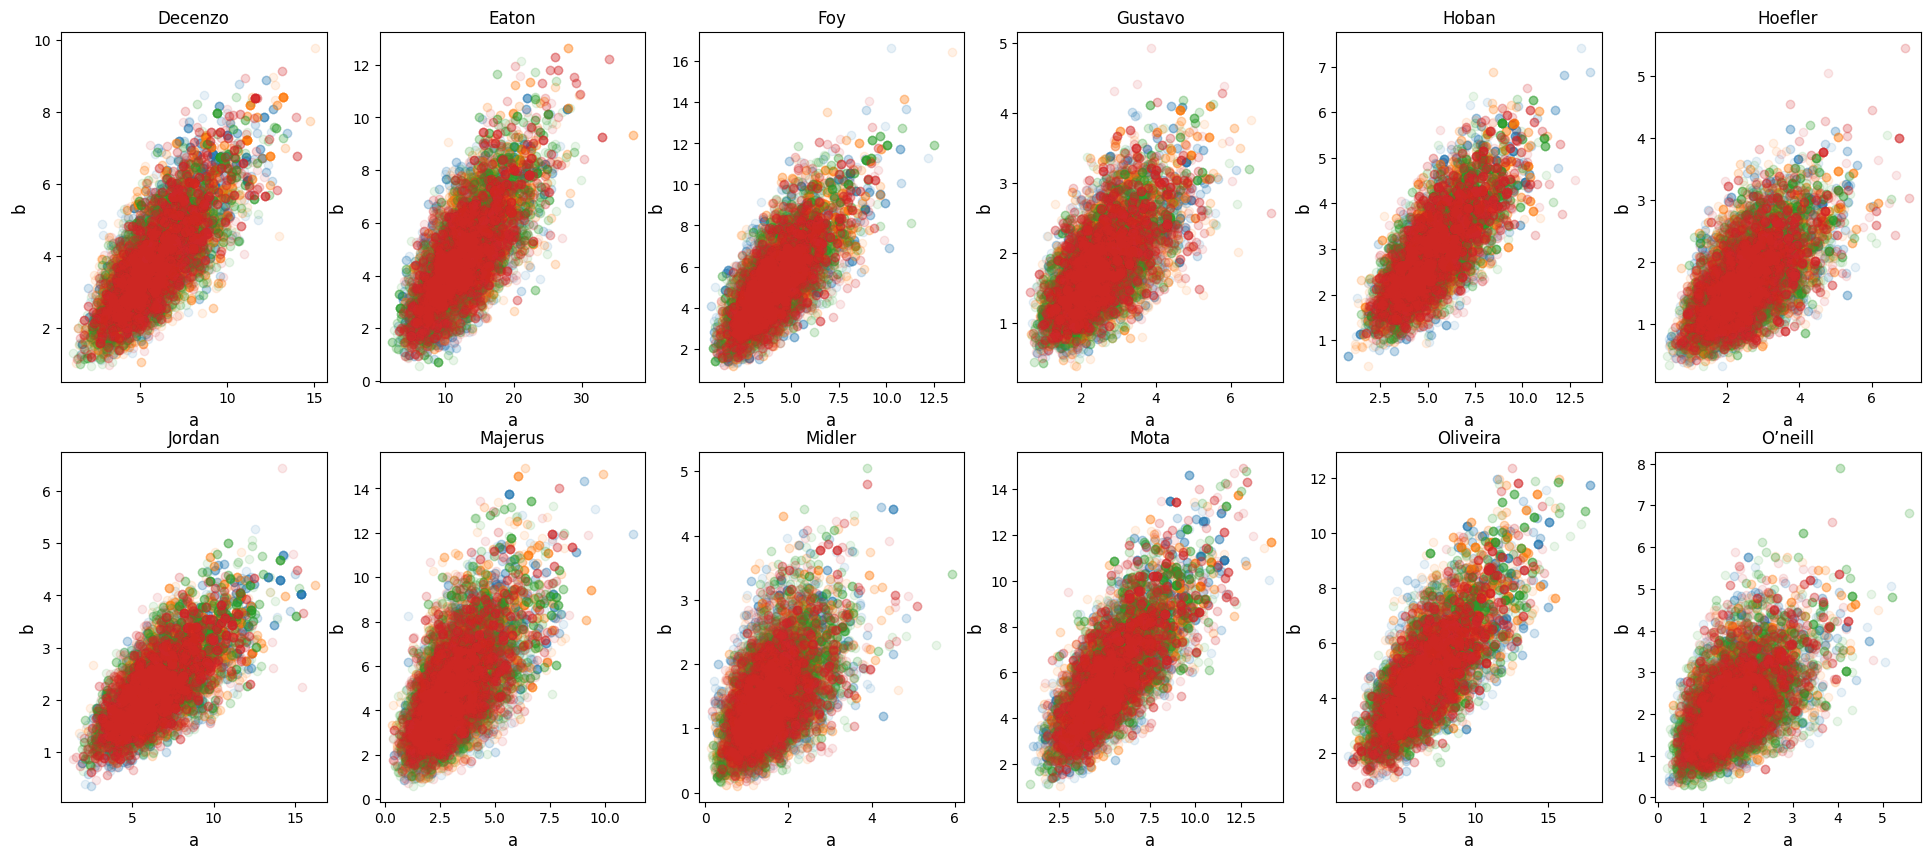

In [321]:
per_row = 6
rows = len(run_samples_dict) // per_row
fig, axs = plt.subplots(rows, per_row, figsize=(24, 10))

# hist of theta, heatmap of alpha and beta
# ignore first 1000 samples
for i, (name, samples) in enumerate(run_samples_dict.items()):
    row = i // per_row
    col = i % per_row
    alpha_tricks, beta_tricks = [[sample[1000:, i] for sample in samples] for i in range(2)]

    for j in range(n_chains):
        axs[row, col].plot(alpha_tricks[j], beta_tricks[j], 'o', alpha=0.1)
        axs[row, col].set_title(f"{name}")
        axs[row, col].set_xlabel('a', fontsize='large')
        axs[row, col].set_ylabel('b', fontsize='large')
    
plt.tight_layout()

In [294]:
bayes_samples = {}
for name, trick_samples in trick_samples_dict.items():
    run_samples = run_samples_dict[name]
    bayes_samples[name] = [np.concatenate([trick_samples[i][1000:], run_samples[i][1000:]], axis=1) for i in range(n_chains)]

In [310]:
# make df of sample mean and variance for each parameter for each skater. only want to look at samples after burn-in
bayesian_params = pd.DataFrame(
    columns=['theta_mean', 'theta_var', 'alpha_trick_mean', 'alpha_trick_var', 'beta_trick_mean', 'beta_trick_var', 'alpha_run_mean', 'alpha_run_var', 'beta_run_mean', 'beta_run_var']
)
for name, samples in bayes_samples.items():
    thetas, alpha_tricks, beta_tricks, alpha_runs, beta_runs = [np.concatenate([sample[:, i] for sample in samples], axis=0) for i in range(5)]
    bayesian_params.loc[name] = [thetas.mean(), thetas.var(), alpha_tricks.mean(), alpha_tricks.var(), beta_tricks.mean(), beta_tricks.var(), alpha_runs.mean(), alpha_runs.var(), beta_runs.mean(), beta_runs.var()]
print(bayesian_params)

           theta_mean  theta_var  alpha_trick_mean  alpha_trick_var  \
Decenzo      0.409683   0.013477         14.025309        19.731119   
Eaton        0.552742   0.024735         14.058501        22.626694   
Foy          0.463413   0.016616         15.563329        24.172197   
Gustavo      0.379415   0.010186         16.146909        24.375550   
Hoban        0.384434   0.010704         18.076631        32.295848   
Hoefler      0.416586   0.013675         13.783271        19.605123   
Jordan       0.377882   0.010725         15.905281        24.941388   
Majerus      0.344709   0.022353          5.755807         5.200927   
Midler       0.312750   0.015861         13.325377        23.084196   
Mota         0.221894   0.012680         11.613794        18.871071   
Oliveira     0.384136   0.017476         14.096269        24.661574   
O’neill      0.236882   0.012767         14.204049        27.122219   
Papa         0.404484   0.013581         13.039261        17.587341   
Ribeir

(d) Använd din bayesiansk modell för [Xi,Yi]T för att simulera 5000 LCQ:ar genom att ta utfall från de lämpliga de aposteriori prediktiva fördelningarna. Vad är typvärdet av dina utfall W1,...,W5000? Hur många av de riktiga vinnarna förutsägs? Vad är den skattade sannolikheten för de riktiga vinnarna baserat på dina utfall? Av typvärdet?

In [314]:
columns = {}
for name, samples in bayes_samples.items():
    idxs = [np.random.choice(range(0, 5000), size=1250, replace=False) for _ in range(4)]
    thetas, alpha_tricks, beta_tricks, alpha_runs, beta_runs = np.concatenate([sample[idxs[i], :] for i, sample in enumerate(samples)], axis=0).T
    columns[name] = simulate_n_LCQs(5000, thetas, alpha_tricks, beta_tricks, alpha_runs, beta_runs)
bayes_scores_df = pd.DataFrame(columns)

In [315]:
LCQ_results(bayes_scores_df)

Vanligaste top 4:
(Eaton, Hoban, Jordan, Shirai)    0.015
Name: count, dtype: float64

Vanligaste top 4 individerna:
Eaton     0.5538
Jordan    0.4484
Shirai    0.4202
Hoban     0.4188
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann tillsammans:
(Decenzo, Eaton, Gustavo, Hoban)    0.0052
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann individuellt:
Decenzo 0.3486
Eaton 0.5538
Gustavo 0.2956
Hoban 0.4188


# 4. En bayesiansk modell med en hierarki. 
##### För att ta hänsyn till möjliga variationer i skateboardåkarnas prestationer mellan olika tävlingar kan vi bygga en modell som använda en hierarki. Som vi såg i föreläsningarna kan vi bygga en bayesiansk hierarki för Vi ∼ Ber(θi) om vi grupperar utfall vi enligt de olika tävlingarna. För enkelhets skull använder vi våra frekventisktiska punktskattningar för parametrarna αi,βi och parametrarna för Yi från uppgift 2.

(a) Anta att Θi|Ci = ci, Di = ci ∼ Beta(ci, di) och välj en lämplig simultan apri- orifördelning för [Θi, Ci, Di]T . (Här är Ci och Di hyperparametrarna för den bayesianska hierarkiska modellen som i råttorna exemplet i föreläsning 11.) Motivera ditt val.

In [298]:
# hierarchical model for theta. use frequentist estimates for alpha and beta
# theta | C = c, D = d ~ Beta(c, d)
# C, D has same function as the previous beta distribution
# V ~ Bin(4, theta)
lamda = 0.5
phi = 10
def log_posterior_hierarchical(data, c, d, n = 4): # ignoring constants
    log_p = log_prior_run(c, d)

    for x in data:
        log_p += loggamma(c + d) - loggamma(c) - loggamma(d) + loggamma(c + x) + loggamma(d + n - x) - loggamma(c + d + n)
    return log_p
    

In [299]:
n_chains = 4
n_samples = 10000
proposal_sd = [0.1, 0.1]
make_cols = [f'make {i}' for i in range(1, 5)]

hierarchy_chains_dict = {}
for name, group in gdf:
    # for each row, calculate the fraction of tricks made
    tricks_made = group[make_cols].sum(axis=1).values 

    # if all trick_made are the same
    if len(set(tricks_made)) == 1:
        mom_c, mom_d = 1, 1
    else:
        mom = estimate_alpha_beta(tricks_made / 4)
        mom_c, mom_d = mom if mom != (0, 0) else (1, 1)

    c_start = np.exp(np.log(mom_c) + stats.cauchy.rvs(size=n_chains, scale=0.05))
    d_start = np.exp(np.log(mom_d) + stats.cauchy.rvs(size=n_chains, scale=0.05))
    print(name, "\n", c_start, "\n", d_start, "\n")
    samples_list = []
    for i in range(n_chains):
        samples = metropolis_algorithm(tricks_made, log_posterior_hierarchical, n_samples, proposal_sd, [c_start[i], d_start[i]])
        samples_list.append(samples[n_samples-5000:])
    hierarchy_chains_dict[name] = samples_list

Decenzo 
 [8.32741113 9.03314892 8.49819522 8.96262084] 
 [10.40618943 12.01633068 10.5263224  11.0327831 ] 

Eaton 
 [8.74334901 9.15652209 8.89007719 9.40336587] 
 [ 2.11626732  5.32806096  2.41660218 10.80644854] 

Foy 
 [2.59310423 2.4985963  2.37482543 2.57855101] 
 [2.68891642 2.32632225 2.38571411 2.49067718] 

Gustavo 
 [1.09043009 0.84943602 1.13466308 1.13543972] 
 [1.51178485 1.48764177 1.76034317 1.69718383] 

Hoban 
 [1.86847703 2.1385528  1.96732319 1.90499544] 
 [1.90254456 2.80459082 3.20052971 2.87565232] 

Hoefler 
 [8.75751804 8.32665679 8.26688508 7.11138562] 
 [14.34435646 11.49964657 11.47222665 11.4548284 ] 

Jordan 
 [4.99342503 6.60431814 5.62980878 5.5931218 ] 
 [10.52255298  9.48870513  7.02512732  7.99743211] 

Majerus 
 [8.75414468 5.49970684 5.17645524 4.9027475 ] 
 [9.18009261 9.00893518 9.16695657 8.41031554] 

Midler 
 [ 3.69703174  4.86162744  5.14567556 13.64200045] 
 [10.3015147  18.38996089  9.60774607 10.10014353] 

Mota 
 [1.43314256 1.01726662 0.

In [300]:
hierarchy_5000_samples_dict = {}
for name, cd_samples in hierarchy_chains_dict.items():
    # take 1250 cd_samples from each chain and concatenate them
    idxs = [np.random.choice(range(0, 5000), size=1250, replace=False) for _ in range(4)]
    cd_samples = np.concatenate([cd_samples[i][idxs[i], :] for i in range(4)], axis=0)
    
    theta_samples = np.array([stats.beta.rvs(c, d) for c, d in cd_samples])

    hierarchy_5000_samples_dict[name] = np.column_stack((theta_samples, cd_samples))

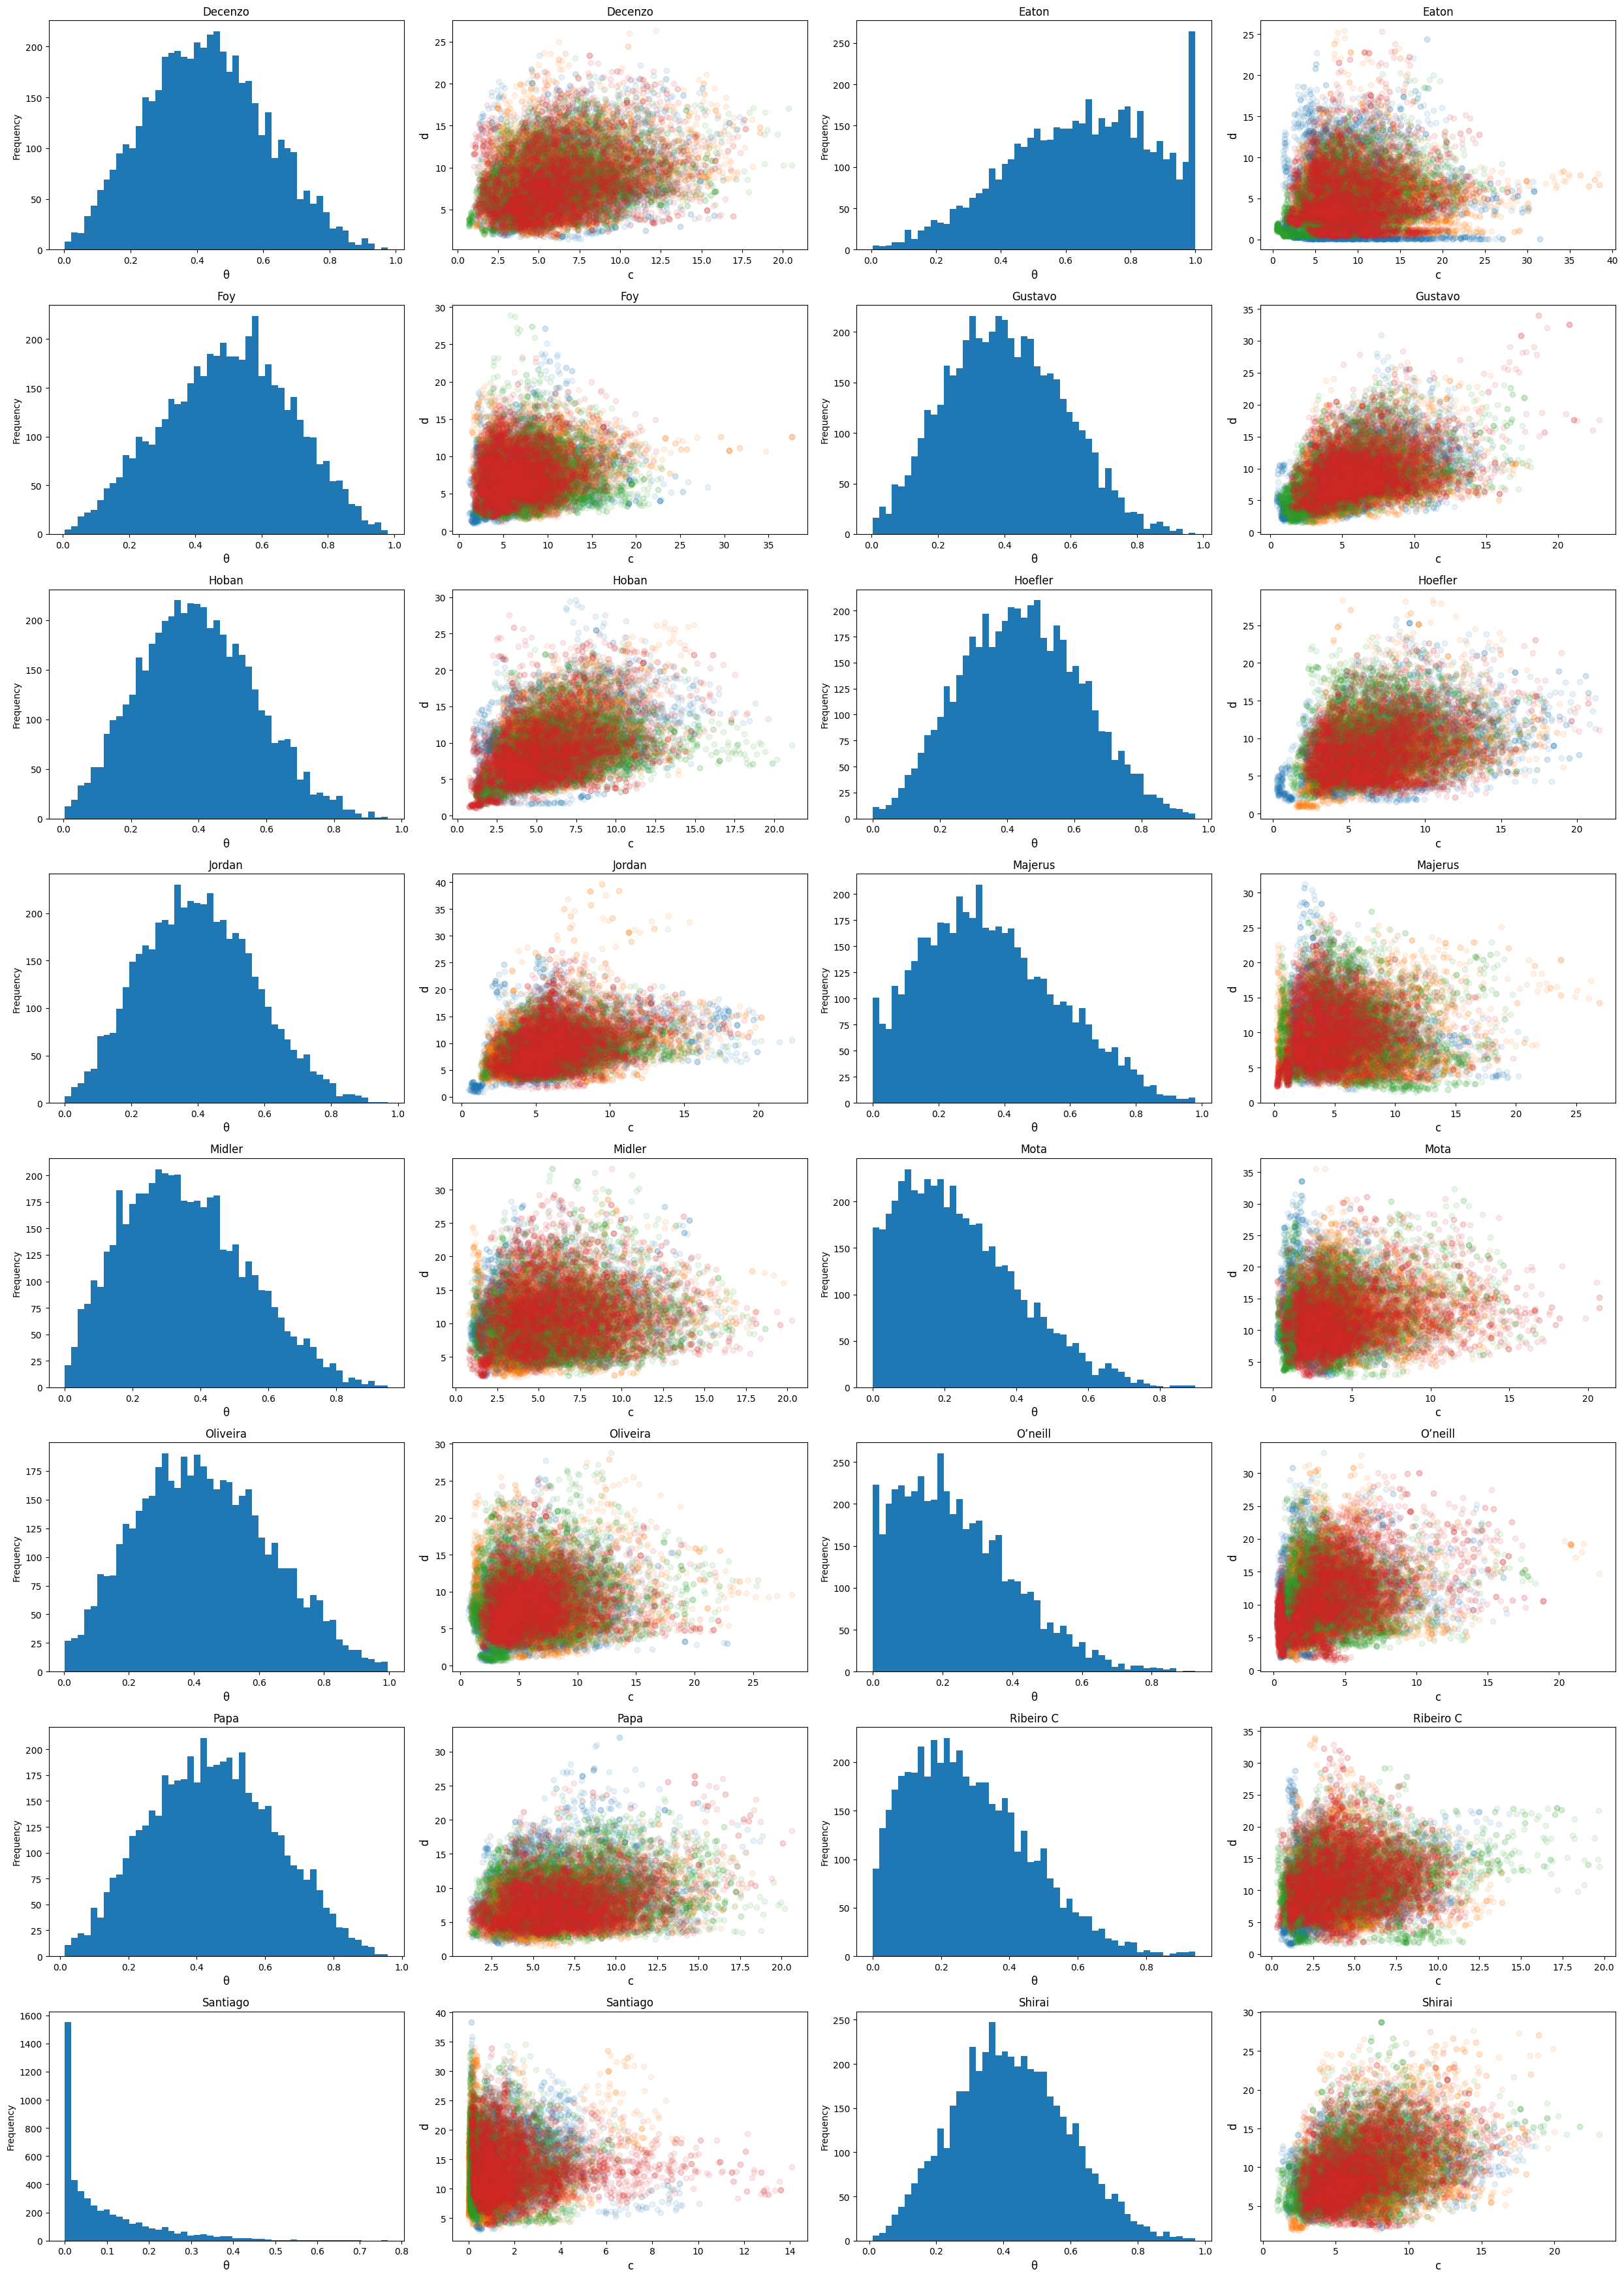

In [301]:
rows = len(trick_samples_dict) // 2
fig, axs = plt.subplots(rows, 4, figsize=(25, 25*1.4))

# hist of theta, heatmap of alpha and beta
# ignore first 1000 samples
for i, (name, samples) in enumerate(hierarchy_5000_samples_dict.items()):
    row = i // 2
    col = 2 * (i % 2)
    
    thetas = samples[:, 0]
    cs, ds = [[sample[:, i] for sample in hierarchy_chains_dict[name]] for i in range(0, 2)]
    
    axs[row, col].hist(thetas, bins=50)
    axs[row, col].set_title(f"{name}")
    axs[row, col].set_xlabel('θ', fontsize='large')
    axs[row, col].set_ylabel('Frequency')
    
    for j in range(n_chains):
        axs[row, col+1].plot(cs[j], ds[j], 'o', alpha=0.1)
        axs[row, col+1].set_title(f"{name}")
        axs[row, col+1].set_xlabel('c', fontsize='large')
        axs[row, col+1].set_ylabel('d', fontsize='large')
    
plt.tight_layout()

In [302]:
hierarchical_params = pd.DataFrame(
    columns=['theta_mean', 'theta_var', 'c_mean', 'c_var', 'd_mean', 'd_var']
)
for name, samples in hierarchy_5000_samples_dict.items():
    thetas, cs, ds = samples.T
    hierarchical_params.loc[name] = [thetas.mean(), thetas.var(), cs.mean(), cs.var(), ds.mean(), ds.var()]
print(hierarchical_params)


           theta_mean  theta_var    c_mean      c_var     d_mean      d_var
Decenzo      0.428131   0.031903  6.280494   8.575657   8.387361  12.690617
Eaton        0.643148   0.048391  9.188967  23.031006   5.171569  13.033502
Foy          0.497295   0.036313  7.557984  14.186084   7.459693  10.687611
Gustavo      0.403908   0.030810  5.931393   8.939753   8.696932  16.588001
Hoban        0.397907   0.028895  6.073570   7.727384   9.331340  15.651802
Hoefler      0.444611   0.032016  6.922154  10.062194   8.757267  14.936033
Jordan       0.403220   0.028709  6.243623   8.199889   9.238169  15.070519
Majerus      0.358729   0.041170  5.576234  11.875150   9.747328  19.544464
Midler       0.355950   0.032917  5.682317   8.705465  10.444788  20.477025
Mota         0.244700   0.026970  4.010528   7.473128  12.050454  20.940966
Oliveira     0.431623   0.041165  6.287535  11.791910   8.296753  15.161924
O’neill      0.242899   0.027213  3.783080   6.715604  11.426783  22.069509
Papa        

In [303]:
avg_bayes_theta_var = bayesian_params['theta_var'].mean()
avg_hier_theta_var = hierarchical_params['theta_var'].mean()
print(f"Average theta variance for Bayesian model: {avg_bayes_theta_var}")
print(f"Average theta variance for hierarchical model: {avg_hier_theta_var}")
print(f"Ratio of theta variance for Hierarchical model vs. Bayesian model: {avg_hier_theta_var / avg_bayes_theta_var}")

Average theta variance for Bayesian model: 0.013965184575812993
Average theta variance for hierarchical model: 0.032011358078977876
Ratio of theta variance for Hierarchical model vs. Bayesian model: 2.2922259211969145


In [304]:
col_dict = {}
for name, samples in hierarchy_5000_samples_dict.items():
    thetas = samples[:, 0]
    freq_row = freq_params.loc[name]
    # frequentist estimates for alpha and beta
    scores = np.empty(len(thetas))
    for i in range(len(thetas)):
        score = 0
        for _ in range(1, 3):
            score += np.random.beta(freq_row['alpha_run'], freq_row['beta_run'])
        for _ in range(1, 5):
            if np.random.uniform() < thetas[i]:
                score += np.random.beta(freq_row['alpha_trick'], freq_row['beta_trick'])
        scores[i] = score
    col_dict[name] = scores
    
hierarchical_scores_df = pd.DataFrame(col_dict)

In [305]:
LCQ_results(hierarchical_scores_df)

Vanligaste top 4:
(Eaton, Hoban, Jordan, Shirai)    0.0104
Name: count, dtype: float64

Vanligaste top 4 individerna:
Eaton     0.6578
Jordan    0.3930
Shirai    0.3632
Foy       0.3300
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann tillsammans:
(Decenzo, Eaton, Gustavo, Hoban)    0.0028
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann individuellt:
Decenzo 0.3098
Eaton 0.6578
Gustavo 0.262
Hoban 0.3266


In [306]:
print(estimate_alpha_beta(np.array([0, 0, 1])))

(0.0, 0.0)
